**Step 1. Construction of eigenfaces** 

Let the random vector $X =
[X_1 ; · · · ; X_N ]$ represent the training set, in which each random variable
X j represents a face image. We identify the notation X = $[X_1 ; · · · ; X_N ]$
with the matrix X whose rows are $X_{j , 1} \leq j \leq n$. Applying PCA on X,
we obtain the average face X̄, the eigenfaces $F_1 , · · · , F_d$ , and the $d \times N$
weight matrix $Y = [y_1 · · · y_N ]$. 

The eigenfaces form an o.n. basis of the
face space $S_d$ . In the weight matrix, the $i^{th}$ column $y_i = [y^i_1 , · · · , y^i_d ]^\prime$
is the weight vector, which approximatively
represents the ith face $X_i$
,
in the training set such that $X_i ≈ \sum^d_{j=1} y_{ji} F j$ .


**Step 2. Computation of the weights** 

Compute the weights of a new in-
put face with respect to eigenfaces and the distance from the new input
face to the face space. Assume that Z is an input image (represented by
a row vector). The weights of Z with respect to eigenfaces are computed
by
$z = F^\prime ∗ (Z − X̄)$,
and the distance from Z to the face space S d is computed by
$d_1 = \|Z − (z^{\prime} F + X̄)\|$.


**Step 3. Face recognition** 

Let $ε_1$ and $ε_2$ be the thresholds for determin-
ing whether an input image is a face and whether it is a known face,
respectively. If $d_1 < ε_1$ , then Z is a face. Otherwise, it is not. In the
case that Z is a face, compute the sum of distances between the weight
vector z and the weight vectors of examples by
$d_2 = \sum_{1\leq i \leq n}(z − y_i )^2 $.

If $d_2 < ε_2$ , Z is assumed to be the face of a person in the training set,
and the person is recognized from the nearest neighbors of Z. Otherwise,
it is assumed to be a new face.

In [1]:
import matplotlib.pyplot as plt 
  
from sklearn.model_selection import train_test_split  
from sklearn.datasets import fetch_lfw_people 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.decomposition import PCA 
  
import numpy as np 

### Importing data using Scikit-learn API

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4) #downloading dataset in our computerb

In [18]:
lfw_people.images.shape # We have 1288 images each of size 50x37

(1288, 50, 37)

In [19]:
n_samples, h, w = lfw_people.images.shape #introspect the images arrays to find the shapes (for plotting)

In [20]:
X = lfw_people.data 

In [21]:
X.shape

(1288, 1850)

In [22]:
n_features = X.shape[1] #Instead of providing 2D data, X has data already in the form  of a vector that is required in this approach. 

In [23]:
#our label for each person name present in the dataset

y = lfw_people.target 

target_names = lfw_people.target_names 

n_classes = target_names.shape[0] 

In [25]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

There are 1288 data samples, with each of size 1850, and we are currently taking pictures of only 7 people.

### How does our data look?

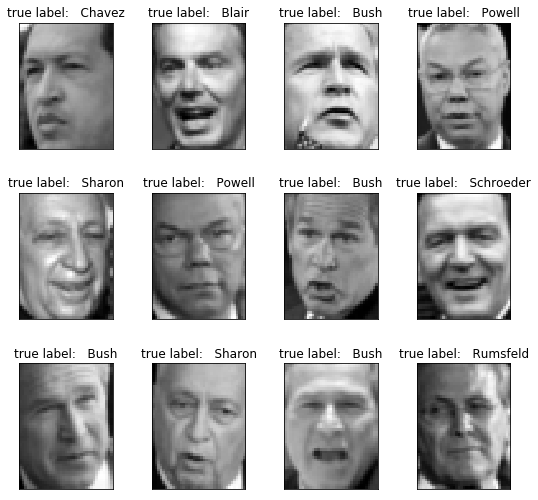

In [26]:
def plot_gallery(images, titles, h, w, n_row = 3, n_col = 4): 
    plt.figure(figsize =(1.8 * n_col, 2.4 * n_row)) 
    plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35) 
    for i in range(n_row * n_col): 
        plt.subplot(n_row, n_col, i + 1) 
        plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray) 
        plt.title(titles[i], size = 12) 
        plt.xticks(()) 
        plt.yticks(()) 

def true_title(Y, target_names, i): 
    true_name = target_names[Y[i]].rsplit(' ', 1)[-1] 
    return 'true label:   % s' % (true_name) 
  

true_titles = [true_title(y, target_names, i) 
                     for i in range(y.shape[0])] 
plot_gallery(X, true_titles, h, w) 


### Splitting the data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

### Applying PCA

In [29]:
n_components = 150

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train) 

#SVD SOLVER MEANS: how much vairance to keep
#whiten : related to normalization
  
eigenfaces = pca.components_.reshape((n_components, h, w)) 
  
#Projecting the input data on the eigenfaces orthonormal basis=>

X_train_pca = pca.transform(X_train) 
X_test_pca = pca.transform(X_test) 


### Visualizing Eigen Faces

The code below generates the EigenFace and each image is represented by a vector of size 1 * 150. The values in this vector represent the coefficient corresponding to that Eigenface.

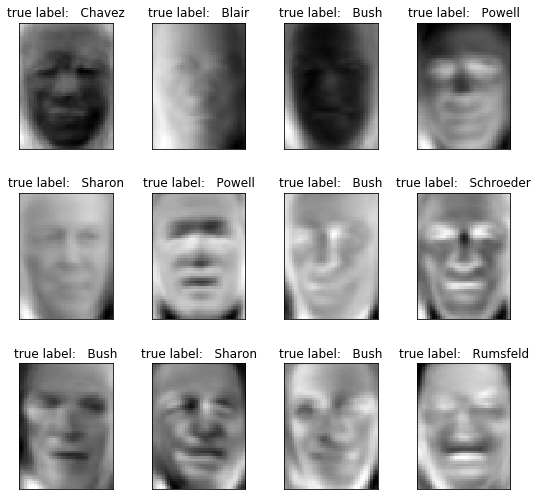

In [31]:
true_titles = [true_title(y, target_names, i) for i in range(y.shape[0])] 

plot_gallery(eigenfaces, true_titles, h, w) 

### Applying SVM for classification

<b> Grid Search for parameter tuning </b>

Grid search is an approach to hyperparameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.

In [35]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC 

In [36]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], } 

clf = GridSearchCV(SVC(kernel ='rbf', class_weight ='balanced'), param_grid ) 

clf = clf.fit(X_train_pca, y_train) 

<b>Best estimator found by grid search:</b>

In [37]:
print(clf.best_estimator_) 

SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


<b>Predicting people's names on the test set:</b>

In [38]:
y_pred = clf.predict(X_test_pca) 

<b>Classifiction results:</b>

In [40]:
print(classification_report(y_test, y_pred, target_names = target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.81      0.87      0.84        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.82      0.98      0.89       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.97      0.78      0.86        36

         accuracy                           0.85       322
        macro avg       0.89      0.71      0.77       322
     weighted avg       0.86      0.85      0.84       322



<b>Confusion Matrix</b>

In [42]:
print(confusion_matrix(y_test, y_pred, labels = range(n_classes))) 


[[  6   2   0   5   0   0   0]
 [  1  52   0   7   0   0   0]
 [  1   2  17   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   3   0   4   1   7   0]
 [  0   1   1   6   0   0  28]]


Visualizing results

In [48]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue: %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

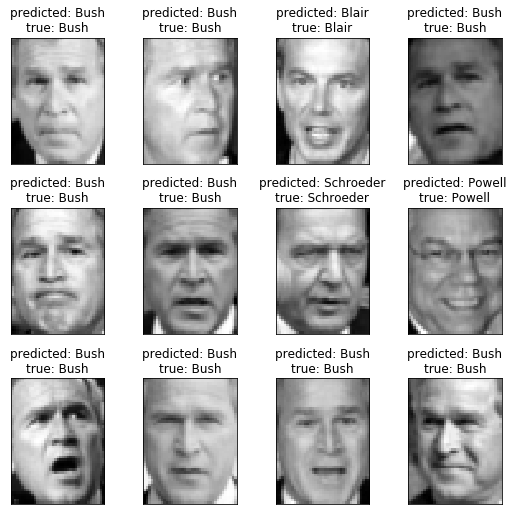

In [49]:
plot_gallery(X_test, prediction_titles, h, w)